In [1]:
import os

import numpy as np
import pandas as pd
# pd.set_option('max_rows', 10)
# pd.set_option('precision', 4)

import matplotlib.pyplot as plt
# plt.style.use('classic')

# IC 分析

# 计算下单目标 weight

## 因子加权

In [2]:
def scale(seri, demean=False):
    '''
    demean=True 表示中性化
    保证权重的绝对值之和等于1
    '''
    if demean == True:
        seri = seri-seri.mean()
    return seri / seri.abs().sum()

# 市场中性化
def factor2weight(factor, demean=True):
    weight = factor.groupby(level=0).apply(scale, demean=demean).rename({'factor': 'weight'}, axis=1)
    return weight

In [3]:
# 只投资因子值在 Top N% 的股票

def cal_pos(seri):
    return (-seri).rank()/seri.count()

def cal_Top_weight(factor, TopN=0.2):
    factor['factor_pos'] = factor['factor'].groupby(level=0).apply(cal_pos)
    Top_mask = factor['factor_pos'] < TopN
    Top_factor = factor.loc[Top_mask,['factor']]
    Top_weight = factor2weight(Top_factor, demean=False)
    return Top_weight

In [4]:
# 纯多组合
# 两种方式：


# 1. 先把factor全部调为正值，再scale

# 2. 只投资factor大于0的股票

## 市值加权

## 等权重（先基于因子进行股票筛选）

# 计算 每日收益 & 每日换手率

In [5]:
# 计算个股的次日收益
def price2forward(price):
    '''
    price：Muti-index df
    '''
    price.columns = ['price']
    price_table = price.pivot_table(values='price', index='trade_date', columns='ts_code').fillna(method='ffill')
    return_table = price_table.diff()/price_table
    forward_return_table = return_table.shift(-1)
    return forward_return_table

In [6]:
# 计算 daily_return 
def get_daily_return(weight, price):
    '''
    weight：Muti-index df
    price：Muti-index df
    '''
    start = weight.index.levels[0][0]
    forward_return_table = price2forward(price)
    weight_table = weight.pivot_table(values='weight', index='trade_date', columns='ts_code')
    daily_return = (forward_return_table*weight_table).sum(axis=1)
    return daily_return.loc[start:]

def get_daily_turnover(weight):
    '''
    weight：Muti-index df
    price：Muti-index df
    '''
    start = weight.index.levels[0][0]
    weight_table = weight.pivot_table(values='weight', index='trade_date', columns='ts_code')
    daily_turnover = weight_table.diff().abs().sum(axis=1)
    return daily_turnover.loc[start:]

In [11]:
# 画图模板
def plot_df(df,title):
    df.plot(
        figsize=(10,5),
        linewidth=0.8,
        title=title,
        grid=True
    )

# 计算 Performance 指标

- CumPNL（cumulated PNL）:累计收益
- Sharpe
- IR
- Yearly Return
- MaxDD

In [8]:

def maxdrawdown(daily_return):
    '''
    Input: 
        daily_return是非对数收益，index为datetime
    Output：
        最大回撤的信息：值、起始日、结束日
    '''
    cap = (daily_return+1).cumprod() # 策略单位净值时间序列
    i = (1 - cap/np.maximum.accumulate(cap)).values.argmax() # end of the period    
    j = (cap[:i]).values.argmax() # start of period
    maxDD = (1-cap[i]/cap[j])    
    # print('maxDD = {:.2f}%  From {} to {}'.format(maxDD*100, cap.index[j].date(), cap.index[i].date()))
    
    return maxDD, cap.index[j], cap.index[i]

def perf_summary(daily_return):
    summary = dict()
    summary['CumReturn'] = (daily_return+1).product()-1
    summary['Sharpe'] = 244**0.5*daily_return.mean()/daily_return.std()
    summary['Yearly_Return'] = (daily_return.mean()+1)**244-1
    summary['MaxDD'] = maxdrawdown(daily_return)[0]

    return pd.DataFrame(summary, index=['Summary'])

def perf_summary_yearly(daily_return):
    yearly_summary = daily_return.resample('Y', kind='period').apply(perf_summary)
    yearly_summary = pd.concat(list(yearly_summary), axis=0)
    yearly_summary.index = daily_return.index.year.unique()
    yearly_summary.index.name = 'year'
    
    return yearly_summary

# API

In [9]:
# 市场中性回测接口

def market_neutral_backtest(factor, price):
    '''
    INPUT:
        weight：Muti-index df
        price：Muti-index df
        
    OUTPUT:
        performance summary: df
        累计收益曲线 + 最大回撤区间: plot
        
    '''
    
    # 计算下单目标weight
    neutral_weight = factor2weight(factor, demean=True) # 中性化多空组合    
    
    # 计算每日收益和换手率
    daily_return = get_daily_return(neutral_weight, price)
    daily_turnover = get_daily_turnover(neutral_weight)
    
    # summary table
    total_summary = perf_summary(daily_return)
    total_summary['Avg_daily_turnover'] = daily_turnover.mean()
    yearly_summary = perf_summary_yearly(daily_return)
    yearly_summary['Avg_daily_turnover'] = daily_turnover.resample('Y', kind='period').mean().values
    summary = pd.concat([yearly_summary, total_summary])
    print(summary)
    summary.to_clipboard()
    
    # 画图：策略累计收益曲线 + 最大回撤区间
    plot_df((daily_return+1).cumprod()-1, 'Cummulative Return')
    maxDD, maxDD_start, maxDD_end = maxdrawdown(daily_return)
    plt.axvline(x=maxDD_start, color="red", linestyle="--")
    plt.axvline(x=maxDD_end, color="red", linestyle="--")

# 调试

         CumReturn    Sharpe  Yearly_Return     MaxDD  Avg_daily_turnover
2014      0.135306  1.507525       0.169299  0.104999            0.256217
2015      1.142319  5.276751       1.165140  0.043243            0.273895
2016      0.353172  3.555257       0.358165  0.042207            0.262316
2017     -0.028827 -0.268053      -0.024635  0.092872            0.247419
2018      0.001585  0.061909       0.005478  0.072278            0.250854
Summary   2.201355  2.292034       0.279351  0.104999            0.258210


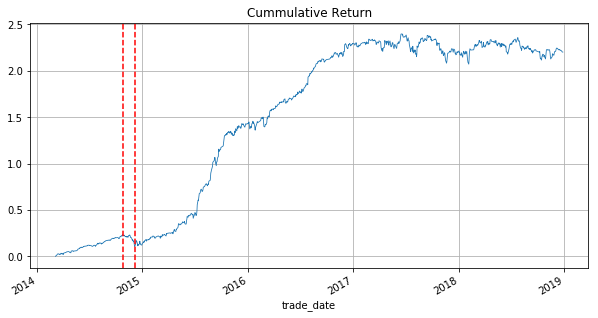

In [12]:
if __name__=='__main__':
    
    # 获取数据：factor & price
    os.chdir(r'C:\Users\瀚\Desktop\回测框架')
    factor = pd.read_csv('factor.csv', index_col=[0,1], parse_dates=['trade_date'])
    bar = pd.read_csv('bar.csv', index_col=[0,1], parse_dates=['trade_date'])
    price = bar[['close']] # 使用close计算收益
    
    market_neutral_backtest(factor, price)